In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from dataloader import read_bci_data
from EEGnet import EEGnet
from DeepConvNet import DeepConvNet

import matplotlib.pyplot as plt

device = torch.device("cuda")
EPOCH = 300

In [2]:
class MyDataset(data.Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels

    def __getitem__(self, index):
        img, target = self.datas[index], self.labels[index]
        return img, target

    def __len__(self):
        return len(self.datas)


train_data, train_label, test_data, test_label = read_bci_data()

train_data = torch.Tensor(train_data).to(device)
train_label = torch.Tensor(train_label).type(torch.LongTensor).to(device)
test_data = torch.Tensor(test_data).to(device)
test_label = torch.Tensor(test_label).type(torch.LongTensor).to(device)

dataset = MyDataset(train_data, train_label)
train_loader = data.DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


epoch: 1/300, Training loss: 0.9023610949516296, Training accuracy: 0.62890625
Test loss: 0.6844357252120972, Test accuracy: 0.67037034034729
epoch: 2/300, Training loss: 0.6073467135429382, Training accuracy: 0.70703125
Test loss: 0.5770799517631531, Test accuracy: 0.7055555582046509
epoch: 3/300, Training loss: 0.5876880884170532, Training accuracy: 0.751953125
Test loss: 0.6213428378105164, Test accuracy: 0.7138888835906982
epoch: 4/300, Training loss: 0.538352370262146, Training accuracy: 0.75390625
Test loss: 0.6393696069717407, Test accuracy: 0.6944444179534912
epoch: 5/300, Training loss: 0.551047146320343, Training accuracy: 0.7763671875
Test loss: 0.5390657186508179, Test accuracy: 0.7351851463317871
epoch: 6/300, Training loss: 0.4823310971260071, Training accuracy: 0.775390625
Test loss: 0.5395515561103821, Test accuracy: 0.7314814925193787
epoch: 7/300, Training loss: 0.611609697341919, Training accuracy: 0.794921875
Test loss: 0.5540807843208313, Test accuracy: 0.737962961

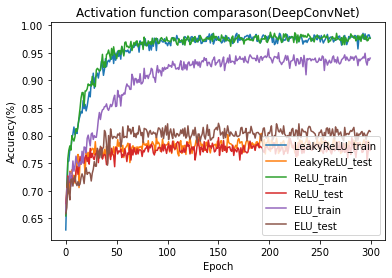

EEGnet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classify): Linear(in_features=736, out_features=2, bias=Tru

In [3]:
'''nets = [
    DeepConvNet(nn.LeakyReLU()).to(device),
    DeepConvNet(nn.ReLU()).to(device),
    DeepConvNet(nn.ELU()).to(device)
]'''
nets = [
    EEGnet(nn.LeakyReLU()).to(device),
    EEGnet(nn.ReLU()).to(device),
    EEGnet(nn.ELU()).to(device)
]
name = ["LeakyReLU", "ReLU", "ELU"]

for i, net in enumerate(nets):
    loss = nn.CrossEntropyLoss()
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    best_test_acc = 0
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.02)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=False, min_lr=0.00001, cooldown=10)

    for epoch in range(1, EPOCH+1):
        total_acc = 0
        total_item = 0
        for (x, y_true) in train_loader:
            y_pred = net(x)
            output = loss(y_pred, y_true)
            net.zero_grad()
            output.backward()
            optimizer.step()


            _, y_pred = torch.max(y_pred.data, 1)
            total_acc += (y_pred == y_true).sum()
            total_item += y_pred.shape[0]

        accuracy = total_acc / total_item
        train_loss.append(output.item())
        train_acc.append(accuracy)
        print(f"epoch: {epoch}/{EPOCH}, Training loss: {output.item()}, Training accuracy: {accuracy}")


        with torch.no_grad():
            y_pred = net(test_data)
            output = loss(y_pred, test_label)

        _, y_pred = torch.max(y_pred.data, 1)
        accuracy = (y_pred == test_label).sum()/train_data.shape[0]
        test_loss.append(output.item())
        test_acc.append(accuracy)
        print(f"Test loss: {output.item()}, Test accuracy: {accuracy}")
        if accuracy > best_test_acc:
            best_test_acc = accuracy

        scheduler.step(output.item())

    plt.plot(train_acc, label=name[i]+"_train")
    plt.plot(test_acc, label=name[i]+"_test")

    print("best acc: ", best_test_acc)

plt.title("Activation function comparason(DeepConvNet)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()




net.eval()